<a href="https://colab.research.google.com/github/neuromatch/climate-course-content/blob/main/projects/project-notebooks/Precipitation_variability_extreme_events_2024.ipynb" target="_blank"><img alt="Open In Colab" src="https://colab.research.google.com/assets/colab-badge.svg"/></a>   <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/neuromatch/climate-course-content/main/projects/project-notebooks/Precipitation_variability_extreme_events_2024.ipynb" target="_blank"><img alt="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"/></a>

# Precipitation Variability and Extreme Events

**Content creators:** Will Gregory, Laura Paccini, Raphael Rocha

**Content reviewers:** Paul Heubel, Jenna Pearson

**Content editors:** Paul Heubel

**Production editors:** Paul Heubel, Konstantine Tsafatinos

**Our 2024 Sponsors:** CMIP, NFDI4Earth


##  Project Background


In [ ]:
# @title Project Background

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
    def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
        self.id = id
        if source == "Bilibili":
            src = f"https://player.bilibili.com/player.html?bvid={id}&page={page}"
        elif source == "Osf":
            src = f"https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render"
        super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
    tab_contents = []
    for i, video_id in enumerate(video_ids):
        out = widgets.Output()
        with out:
            if video_ids[i][0] == "Youtube":
                video = YouTubeVideo(
                    id=video_ids[i][1], width=W, height=H, fs=fs, rel=0
                )
                print(f"Video available at https://youtube.com/watch?v={video.id}")
            else:
                video = PlayVideo(
                    id=video_ids[i][1],
                    source=video_ids[i][0],
                    width=W,
                    height=H,
                    fs=fs,
                    autoplay=False,
                )
                if video_ids[i][0] == "Bilibili":
                    print(
                        f"Video available at https://www.bilibili.com/video/{video.id}"
                    )
                elif video_ids[i][0] == "Osf":
                    print(f"Video available at https://osf.io/{video.id}")
            display(video)
        tab_contents.append(out)
    return tab_contents


video_ids = [('Youtube', '49XHRe61LI8'), ('Bilibili', 'BV1Au411L7fo')]
tab_contents = display_videos(video_ids, W=730, H=410)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
    tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @markdown
from IPython.display import IFrame
from ipywidgets import widgets
out = widgets.Output()
with out:
    print(f"If you want to download the slides: https://osf.io/download/djpgh/")
    display(IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/djpgh/?direct%26mode=render%26action=download%26mode=render", width=730, height=410))
display(out)

Output()

**In this project**, you will explore rain gauge and satellite data from the CHIRPS data set to extract rain estimates and land surface reflectance, respectively. These data will enable identification of extreme events in your region of interest. Besides investigating the relationships between these variables, you are encouraged to study the impact of extreme events on changes in vegetation.

# Project Template

<img src='../template-images/2024_Precipitation.svg'/>

## Data Exploration Notebook

## Project Setup

In [ ]:
# google colab installs

#!pip install --quiet s3fs boto3 botocore

In [ ]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pooch
import os
import tempfile
import pandas as pd
import s3fs
import boto3
import botocore
import datetime

###  Helper functions


In [ ]:
# @title Helper functions

def pooch_load(filelocation=None,filename=None,processor=None):
    shared_location='/home/jovyan/shared/Data/Projects/Precipitation' # this is different for each day
    user_temp_cache=tempfile.gettempdir()

    if os.path.exists(os.path.join(shared_location,filename)):
        file = os.path.join(shared_location,filename)
    else:
        file = pooch.retrieve(filelocation,known_hash=None,fname=os.path.join(user_temp_cache,filename),processor=processor)

    return file

###  Figure settings


In [ ]:
# @title Figure settings

import ipywidgets as widgets       # interactive display

%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/neuromatch/climate-course-content/main/cma.mplstyle")

## CHIRPS Version 2.0 Global Daily 0.25°

The Climate Hazards Group InfraRed Precipitation with Station data (CHIRPS) is a high-resolution precipitation dataset developed by the Climate Hazards Group at the University of California, Santa Barbara. It combines satellite-derived precipitation estimates with ground-based station data to provide gridded precipitation data at a quasi-global scale between 50°S-50°N. 

Read more about CHIRPS here:

* [The climate hazards infrared precipitation with stations—a new environmental record for monitoring extremes](https://www.nature.com/articles/sdata201566)

* [Climate Hazard Group CHG Wiki](https://wiki.chc.ucsb.edu/CHIRPS_FAQ)

* [Data storage location](https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/netcdf/p25/)

### Indices for Extreme Events
The Expert Team on Climate Change Detection and Indices ([ETCCDI](http://etccdi.pacificclimate.org/list_27_indices.shtml)) has defined various indices that focus on different aspects such as duration or intensity of extreme events. The following functions provide examples of how to compute indices for each category. You can modify these functions to suit your specific needs or create your own custom functions. Here are some tips you can use:

- Most of the indices require daily data, so in order to select a specific season you can just use `xarray` to subset the data. Example:

```python
daily_precip_DJF = data_chirps.sel(time=data_chirps['time.season']=='DJF')
```

- A common threshold for a wet event is precipitation greater than or equal to $1 \text{ mm}/\text{day}$, while a dry (or non-precipitating) event is defined as precipitation less than $1 \text{ mm}/\text{day}$.
- Some of the indices are based on percentiles. You can define a base period climatology to calculate percentile thresholds, such as the 5th, 10th, 90th, and 95th percentiles, to determine extreme events (cf. in particular W2D3).

In [ ]:
def calculate_cdd_index(data):
    """
    This function takes a daily precipitation dataset as input and calculates
    the Consecutive Dry Days (CDD) index, which represents the longest sequence
    of consecutive days with precipitation less than 1mm. The input data should
    be a DataArray with time coordinates, and the function returns a DataArray
    with the CDD values for each unique year in the input data.
    Parameters:
    ----------
      - data (xarray.DataArray): The input daily precipitation data should be
      a dataset (eg. for chirps_data the DataArray would be chirps_data.precip)
    Returns:
    -------
      - cdd (xarray.DataArray): The calculated CDD index

    """
    # create a boolean array for dry days (PR < 1mm)
    dry_days = data < 1
    # initialize CDD array
    cdd = np.zeros(len(data.groupby("time.year")))
    # get unique years as a list
    unique_years = list(data.groupby("time.year").groups.keys())
    # iterate for each day
    for i, year in enumerate(unique_years):
        consecutive_trues = []
        current_count = 0
        for day in dry_days.sel(time=data["time.year"] == year).values:
            if day:
                current_count += 1
            else:
                if current_count > 0:
                    consecutive_trues.append(current_count)
                    current_count = 0
        if current_count > 0:
            consecutive_trues.append(current_count)
        # print(consecutive_trues)
        # CDD is the largest number of consecutive days
        cdd[i] = np.max(consecutive_trues)
    # transform to dataset
    cdd_da = xr.DataArray(cdd, coords={"year": unique_years}, dims="year")
    return cdd_da

In [ ]:
# code to retrieve and load the data

years = range(1981,2024) # the years you want. we want 1981 till 2023
file_paths = ['https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/netcdf/p25/chirps-v2.0.' + str(year) + '.days_p25.nc' for year in years] # the format of the files
filenames = ['chirps-v2.0.'+str(year)+'.days_p25.nc' for year in years] # the format of the files

downloaded_files=[ pooch_load(fpath,fname) for (fpath,fname) in zip(file_paths,filenames)] # download all of the files

#### open data via xarray
chirps_data = xr.open_mfdataset(
    downloaded_files, combine="by_coords"
)  # open the files as one dataset

SHA256 hash of downloaded file: abf5aa47db1a47b1bb0358591d02adb7cdc765af1de83834aa0a36157828f0cb
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: 5264a039135cbe00fff7c2b8296123ddc652db67a3086ac1d84bc7cfd91d1b3c
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: 8083ed549a4027fddad74e4a3be75c8587ad0830de3be0200c56b295d81cbe26
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: e1c3edab18b4bd69a659a42e95ca9a97051b7055738fdf4b63796ff199bbf2a4
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: 795f6ef239d5a88b0afc682875ad5567f61d694980346c656db5445af428b3ab
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: 3ad6497e71ee565d2ecdb895993f2ca9b4db6ed0efb702eb000b934b7ea4438f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: a47dd1314d10589213b7d807fb8f1486972f2a0fcf081d899b414304c09aad8d
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: 07b7a89ac7e7f1e16cad1db1100217a60a124964b77693e6323b0c1316f813e3
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: a81c7a0916bf81e4047cda8d6320cc5c94720f758f232c50b80502a840702ab8
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: 10a95daa84df0e1934c462c3687cff0accff907557f92c6c1e7ee0d2077ed0d4
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: f549808c69601cf288b4f0f42b8ac5337c348f06d1fb55aa86b67e9bbd3837f9
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: ae26310b18369c1015e6b70db6dfb7ad1c138f846bd7c322e0b6794a26423f56
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: 292ff168ef7f4420d36606f7ed84aa5380dd979a90351762926ef4c569e90f56
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: f856963801db2a62fa5c35537810f1649f19d32c84f1c4f2bb3fd3dcc82ba7ec
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: 54c7a408d49112465479a06a3d1e5b37cb10b526c2cf20215f2b75579c8c2a0e
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: b0a4604e5a213671e6d591ad959c2156685ee026b54fbc8ad87860e35f3db4df
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: a04019a26e20988e35d8d14e88f1083aabb8104434c556c21e3d29e1c30ae731
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: 15f3e33707c14b3ef26b525cb116766b847f2295c60aa41c6ae73df10e748e98
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: dbb0a6a0ee1ff5e3ba5439101bedc24dad0951810a03a6f5cdc96e4b08c06716
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: 57014c9ff72c8997b5b141793c06ffd1a8d8f5c6d1308789ac8e12c3860e5790
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: 8550c96c7f8c29cbc6a1be3be56d7f769125d15b9ac7bc6c4f0fc4a76034f0fa
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: 8027aaf7e005d74073d2c744d9c8a0343ffade272c1d1f8c420972bcbade2231
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: 5b5a538e187ca651bc1fcc25eb445d31a05067b5a109bd8bb4651db11346cf6f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: 5e671526f27567e9218d275f7a47b6c0d7e0acf718edfee64c5843f5ee497e93
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: 2185afd5c3d110da52a9a81eb97f25b37f30db5c0478e536a84c957351e44b53
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: 3f78d5e733ea38bef25e47af9b3a907a96e27b8334cc04e4898837239e6539e6
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: c4594aeaafd7b9e7065577563799bca461582723e6b32df332206b43cb853138
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: 6fe5dc8facd7750b6c08ecd0cadaaf19570acccd6a15f20efcbdd960230b5551
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: e6ccdc38aa146793f2c92858412122ef14a7a34332940bec03bd520cc77dc235
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: f6b6bd962626c038959a743b5f6e6c22b0bd6647b89b4a08b0f2305ac77f7277
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: 45f437d8f1c7237b7043ebf4fec800461252af02e7cbcc87a844ddf0d1a911d2
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: 27792b3d028ca5e745a8fe45c4f133a4183469512d2e55ead950d54a5a5a890b
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: d531a704ed1a40be2d509b1d984913194015f84721edc555f2de8c000bcab638
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: c3225de85da99422bc5fde9dbd1bdabff206fc2902d811944169348c8352d521
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: 0c770adf07884a25610ea00d66d5e221529159746d3d76d9affea69c77666233
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: 8ff4f6284c1d37b50e8b1e47dbd9f6e108a9ee3b17a6752bb18cc0b7384526d3
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: 9692ca1fee495b8091084b1e5d29ea618483e67886a281f82b4a03555861d6b8
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: 05b0850b8b8c16a2d5d33ddc6ba89d503084dc7374845214289be1b411a30d3f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: 311723f2f8d2af3307da198ebafece0c081200f336444a4261516539348fed38
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: 2ab3b142141c5cfc708bc666dc89900005b7452b66324515fca1baa8dff00402
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: 1b2db33508896ed1932b9db7e6dad6136e90687d3fe630f08066dbd279e0dabb
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: 5f9b88f0623083759ba351a263bf23afd7fb26b13e23d051d5bb22a55aa0bcb9
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: 8430cc8afd1a69205ecf757a2d8d95f3e6fbc44544326b27b4d534a82ee9c14c
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


We can now visualize the content of the dataset.

In [ ]:
# code to print the shape, array names, etc of the dataset
chirps_data

<xarray.Dataset> Size: 36GB
Dimensions:    (latitude: 400, longitude: 1440, time: 15705)
Coordinates:
  * latitude   (latitude) float32 2kB -49.88 -49.62 -49.38 ... 49.38 49.62 49.88
  * longitude  (longitude) float32 6kB -179.9 -179.6 -179.4 ... 179.6 179.9
  * time       (time) datetime64[ns] 126kB 1981-01-01 1981-01-02 ... 2023-12-31
Data variables:
    precip     (time, latitude, longitude) float32 36GB dask.array<chunksize=(61, 67, 240), meta=np.ndarray>
Attributes: (12/15)
    Conventions:       CF-1.6
    title:             CHIRPS Version 2.0
    history:           created by Climate Hazards Group
    version:           Version 2.0
    date_created:      2015-10-07
    creator_name:      Pete Peterson
    ...                ...
    reference:         Funk, C.C., Peterson, P.J., Landsfeld, M.F., Pedreros,...
    comments:           time variable denotes the first day of the given day.
    acknowledgements:  The Climate Hazards Group InfraRed Precipitation with ...
    ftp_url:           ftp://chg-ftpout.geog.ucsb.edu/pub/org/chg/products/CH...
    website:           http://chg.geog.ucsb.edu/data/chirps/index.html
    faq:               http://chg-wiki.geog.ucsb.edu/wiki/CHIRPS_FAQ

## NOAA Fundamental Climate Data Records (FCDR) AVHRR Land Bundle - Normalized Difference Vegetation Index

As we learned in the W1D3 tutorials, all the National Atmospheric and Oceanic Administration Climate Data Record (NOAA-CDR) datasets are available both at NOAA National Centers for Environmental Information (NCEI) and commercial cloud platforms. See the link [here](https://registry.opendata.aws/noaa-cdr-terrestrial/). We are accessing the data directly via the [Amazon Web Service (AWS) cloud storage space](https://noaa-cdr-ndvi-pds.s3.amazonaws.com/index.html).

For this project, we recommend using the Normalized Difference Vegetation Index (NDVI). It is one of the most commonly used remotely sensed indices. It measures the "greenness" of vegetation and is useful in understanding vegetation density and assessing changes in plant health. For example, NDVI can be used to study the impacts of droughts, heatwaves, and insect infestations on plants covering Earth's surface. A good overview of this index from this particular sensor can be accessed [here](https://digitalcommons.unl.edu/nasapub/217/).

Recall what we learned in W1D3 Tutorial 3, the data files on AWS are named systematically:

> Sensor name: `AVHRR`  
> Product category: `Land`  
> Product version: `v005`  
> Product code: `AVH13C1`  
> Satellite platform: `NOAA-07`  
> Date of the data: `19810624`  
> Processing time: `c20170610041337` (*This will change for each file based on when the file was processed*)  
> File format: `.nc` (*netCDF-4 format*)

In other words, if we are looking for the data of a specific day, we can easily locate where the file might be. 

For example, if we want to find the AVHRR data for the day of *2002-03-12 (or March 12, 2002)*, you can use:

`s3://noaa-cdr-ndvi-pds/data/2002/AVHRR-Land_v005_AVH13C1_*_20020312_c*.nc`

The reason that we put `*` in the above directory is that we are not sure about what satellite platform this data is from and when the data was processed. The `*` is called a **wildcard**, and is used because we want *all* the files that contain our specific criteria, but do not want to have to specify all the other pieces of the filename we are not sure about yet. It should return all the data satisfying that initial criteria and you can refine further once you see what is available. Essentially, this first step helps to narrow down the data search. You can then use this to create datasets from the timeframe of your choosing.

*Note the download might take up to hours depending on your time frame of interest and your device. Choose your time frame wisely before taking action to avoid unnecessary data retrieval amounts.*

In [ ]:
# we can access the data similar to Tutorial 3 of W1D3
# to access the NDVI data from AWS S3 bucket, we first need to connect to s3 bucket

fs = s3fs.S3FileSystem(anon=True)
client = boto3.client('s3', config=botocore.client.Config(signature_version=botocore.UNSIGNED)) # initialize aws s3 bucket client
# choose a date of interest, we pick its year or month while defining the file_location
date_sel = datetime.datetime(2001,1,1,0)

file_location = fs.glob('s3://noaa-cdr-ndvi-pds/data/'
                        + date_sel.strftime('%Y')
                        + '/AVHRR-Land_v005_AVH13C1_*'
                        + date_sel.strftime("%Y%m") # or "%Y" for the entire year
                        + '*_c*.nc') # the files we want for a whole year/month
files_for_pooch=[pooch_load('http://s3.amazonaws.com/'+file,file) for file in file_location]

ds = xr.open_mfdataset(files_for_pooch, combine="by_coords", decode_times=False)  # open the file
ds

SHA256 hash of downloaded file: bea1b2cfeead6742dd8e6006533d447a1cfd6f7311fbc8a662f5f0b58ac65500
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: 3b8037793f3699a79d3d2c6d5413966a356d4b1e27d853555231961616fe40b6
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: a92fd5e6188556cd35511394312fb4f5ecf4d7e7153fc4002f29d23316463340
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: 21c0f5e7b361eeed45bad648c12b3d88c670da77e81ed36d0c83e7daa59e0ece
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: fc7d244edf3dd0eec1609ed9aeca5d94c479f8115a38c9cf879efa889046a66d
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: 260c939a2b10f35eafe6ebd67c9b9d260062e7c455a1b7268f6bafaec4e9edf0
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: 85f0e58ce20cf1fcacdb8856b2bc805a073e7d349de2816c4c71d18c35f88de7
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: 3dc1a63efd5439b5c7c30421dfc3f19918d03719ee824c5bba9f28842a133748
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: 5c1ddfbe3f562b8fcd84a5f2c294aa5ae804f6a9c686ea21e7a019c2434b2ce1
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: 4c270d4cd8c43a3e8830477f681fdc7f492acdbeb517fbb9fa002246955d6468
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: dbb9c7c2a17fa376727a6d6efed7dba915222439678c9fe28fef8f93c283f9a0
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: 2443ca0d7294da9555a462c2c6af5620342688522ee9a6197606ca91551848b6
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: a91b0ccd4216729443aaba8875de29ddcf0968789ce86b2abf06984abcb1ab9b
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: 80aacb1b012bc917fd0ebbcccf793062f8a490031a21cede4f8e6ab6bd59f45e
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: e3b97d2052ece810cf14f3c7ad428d30e9e9acf98aa2082684f8f3986a6f05aa
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: 317ece4c8925f74e93d6111c15f8a5d78231da91f47c98b3432ad9a9d6dd5e0c
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: d1a98e00eb1cf5524eab70e5d0cefb793f789c653c010c5af5fd7b641a0453ec
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: 48710d5c1cc845f35ba23c528ac9e592fd4d9b7c9961d1ddb31ac1ce7880f829
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: 1a8dbe37b9f48e28e1ad24c7002cdc4e132413668e63f856ff30a34ab2e49bf5
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: 6419dc7f01e8725ebc3db108b770d64c6221fc61acb824959bbe5a246faec097
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: 365b748dce06c1731a03162855d25ee4467fcb94fa7c623f82f8c407fa4ea88e
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: 2d1904144d4459967c49f4b197a4e35ca1fea352f1eea41732daa679af81378f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: 83d678770250b0fc8169c72b648da9ad6d11843b8c73250b4857c5ee18b5287c
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: 3cc82111ca3ce5f58948c31af1778d46401ed4ec61403b8a374d1d690ce7f9ec
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: 04618e326461457b9ec9495ad527a82845bd7e363f53705f4e47fdac6383d83d
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: 1022477d48371e7df468f8699bebd9716ea19ee104e397919ce61cd2b178bec2
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: 81f12834cf32df6171e65db33afd90fbfd65027330aa0b21cbd0ea6088c8280a
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: cf1b2f7bb2ede9ff76917f77681d8c0cf8c8e9b8cbaa43b315613e848ea2d6ab
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: 20b5d6c84a736057d6fa8def6857a7e507fd95ae5c265da893692788b59c7497
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: c2122ad87a08bf38ce1b38f6d03bdf783209431dcd45a1d37be07c4385f88eb5
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


SHA256 hash of downloaded file: d5c1b61b554941b79caf7731fe49a6dfcddeed08777dd516c3cf6505c6834ad1
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


<xarray.Dataset> Size: 11GB
Dimensions:    (latitude: 3600, longitude: 7200, time: 31, ncrs: 1, nv: 2)
Coordinates:
  * latitude   (latitude) float32 14kB 89.97 89.93 89.88 ... -89.93 -89.97
  * longitude  (longitude) float32 29kB -180.0 -179.9 -179.9 ... 179.9 180.0
  * time       (time) float32 124B 7.305e+03 7.306e+03 ... 7.334e+03 7.335e+03
Dimensions without coordinates: ncrs, nv
Data variables:
    crs        (time, ncrs) int16 62B dask.array<chunksize=(1, 1), meta=np.ndarray>
    lat_bnds   (time, latitude, nv) float32 893kB dask.array<chunksize=(1, 3600, 2), meta=np.ndarray>
    lon_bnds   (time, longitude, nv) float32 2MB dask.array<chunksize=(1, 7200, 2), meta=np.ndarray>
    NDVI       (time, latitude, longitude) float32 3GB dask.array<chunksize=(1, 1200, 2400), meta=np.ndarray>
    TIMEOFDAY  (time, latitude, longitude) float64 6GB dask.array<chunksize=(1, 1200, 2400), meta=np.ndarray>
    QA         (time, latitude, longitude) int16 2GB dask.array<chunksize=(1, 3600, 7200), meta=np.ndarray>
Attributes: (12/48)
    title:                                  Normalized Difference Vegetation ...
    institution:                            NASA/GSFC/SED/ESD/HBSL/TIS/MODIS-...
    Conventions:                            CF-1.6, ACDD-1.3
    standard_name_vocabulary:               CF Standard Name Table (v25, 05 J...
    naming_authority:                       gov.noaa.ncei
    license:                                See the Use Agreement for this CD...
    ...                                     ...
    PercentValidDaytimeData:                33.79
    PercentValidDaytimeLand:                33.79
    PercentValidClearDaytimeLand:           4.54
    PercentValidDaytimeLandInCloudShadow:   0.85
    PercentValidClearDaytimeWater:          0.00
    PercentValidDaytimeWaterInCloudShadow:  0.00

If the above downloading procedure is not working as expected, please retrieve the following sample to execute the remaining cells of the notebook. Ask for the help of your project TA to download your data of interest.


In [ ]:
# uncomment to get a subsample of AVHRR-Land_v005_AVH13C1_NOAA-16 NDVI data if data retrieval above is not working properly

#fname_ndvi_200101 = 'AVHRR-Land_v005_AVH13C1_NOAA-16_200101.nc'
#link_id_ndvi = "a9v7h"
#url_ndvi_200101 = f"https://osf.io/download/{link_id_ndvi}/"
#
#ds = xr.open_dataset(pooch_load(url_ndvi_200101, fname_ndvi_200101))
#ds

*Note that the downloaded satellite data is quality-controlled and flagged accordingly. Please refer to W1D3 Tutorial 3 and others to decipher it. Choose the feasible helper functions, e.g. `get_quality_info_AVHRR(QA)` depending on the sensor of interest. VIIRS is a state-of-the-art sensor that produces measurements that have been available since 2014. We provide an example of usage in the following.*

In [ ]:
# AVHRR: function to extract high-quality NDVI data
def get_quality_info_AVHRR(QA):
    """
    QA: the QA value read in from the NDVI data

    High-quality NDVI should meet the following criteria:
    Bit 7: 1 (All AVHRR channels have valid values)
    Bit 2: 0 (The pixel is not covered by cloud shadow)
    Bit 1: 0 (The pixel is not covered by cloud)
    Bit 0:

    Output:
    True: high quality
    False: low quality
    """
    # unpack quality assurance flag for cloud (byte: 1)
    cld_flag = (QA % (2**2)) // 2
    # unpack quality assurance flag for cloud shadow (byte: 2)
    cld_shadow = (QA % (2**3)) // 2**2
    # unpack quality assurance flag for AVHRR values (byte: 7)
    value_valid = (QA % (2**8)) // 2**7

    mask = (cld_flag == 0) & (cld_shadow == 0) & (value_valid == 1)

    return mask

In [ ]:
# get the quality assurance value from NDVI data
QA = ds.QA

# create the high quality information mask
mask = get_quality_info_AVHRR(QA)

# check the quality flag mask information
#mask

In [ ]:
# mask ndvi data
ndvi_masked = ds.NDVI.where(mask)
ndvi_masked

<xarray.DataArray 'NDVI' (time: 31, latitude: 3600, longitude: 7200)> Size: 3GB
dask.array<where, shape=(31, 3600, 7200), dtype=float32, chunksize=(1, 1200, 2400), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 14kB 89.97 89.93 89.88 ... -89.93 -89.97
  * longitude  (longitude) float32 29kB -180.0 -179.9 -179.9 ... 179.9 180.0
  * time       (time) float32 124B 7.305e+03 7.306e+03 ... 7.334e+03 7.335e+03
Attributes:
    long_name:      NOAA Climate Data Record of Normalized Difference Vegetat...
    units:          1
    valid_range:    [-1000 10000]
    grid_mapping:   crs
    standard_name:  normalized_difference_vegetation_index

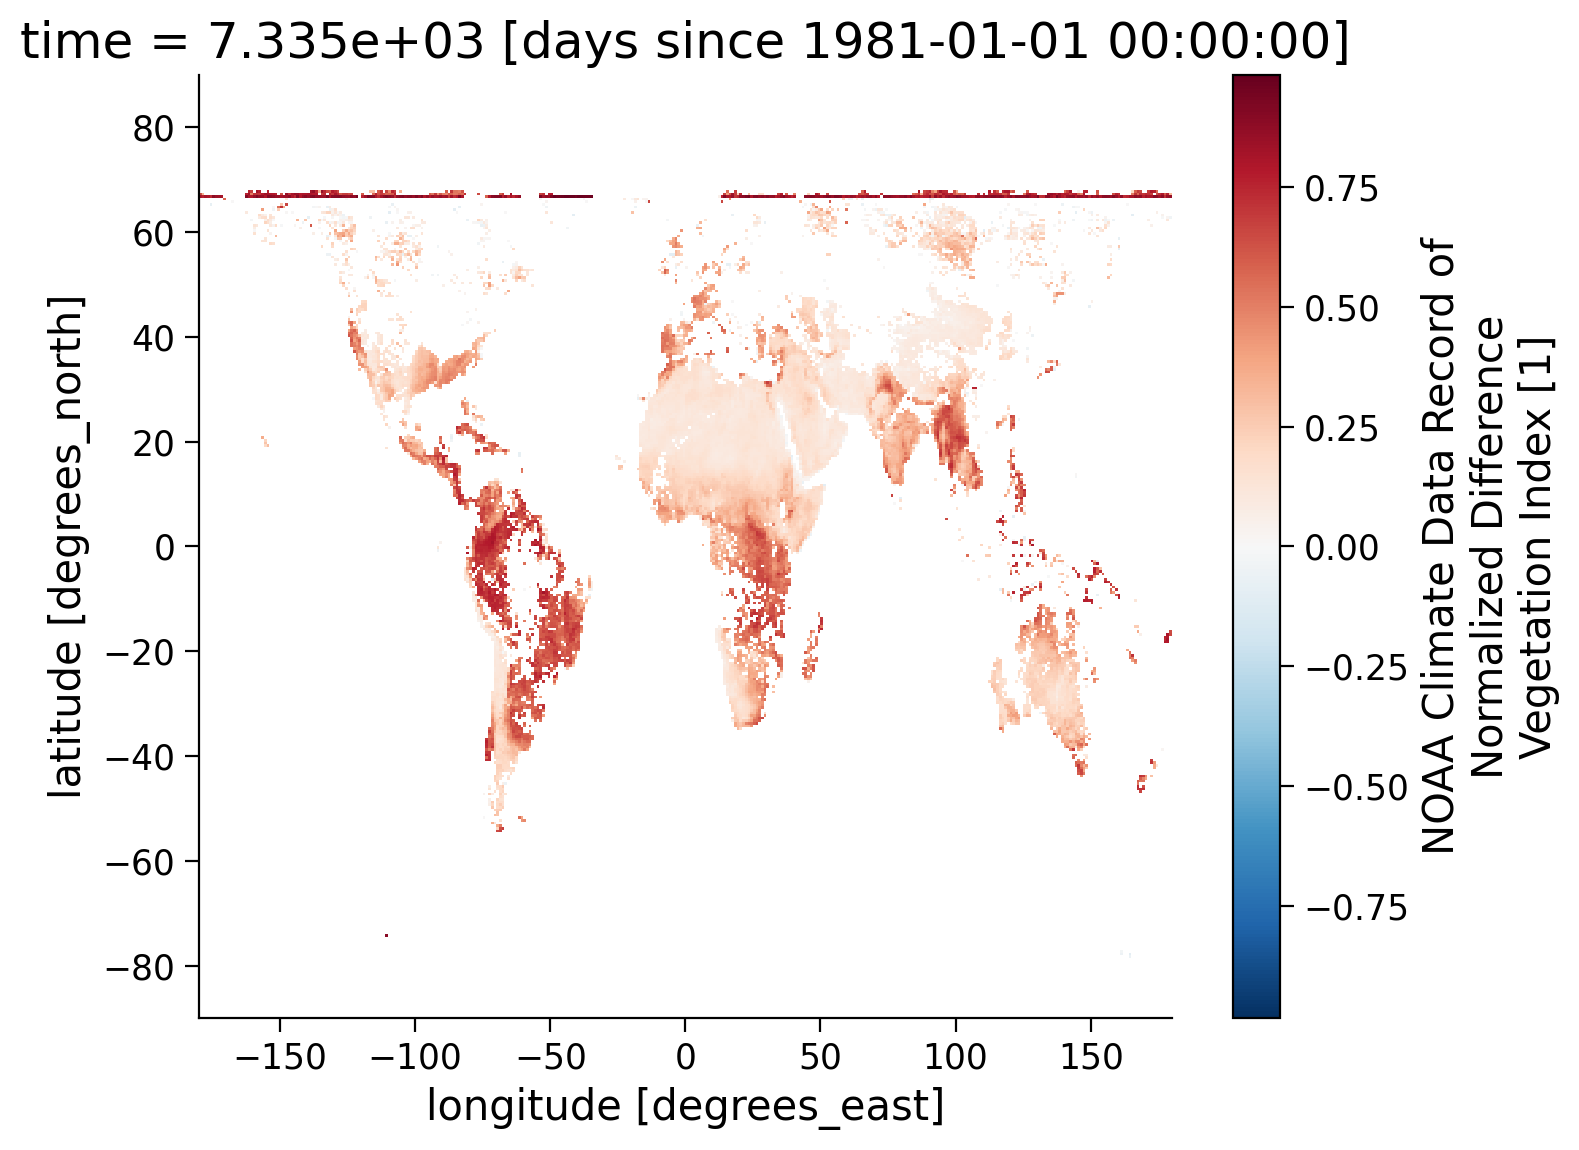

In [ ]:
# draw data to an example plot
ndvi_masked.isel(time=30).coarsen(latitude=10).mean().coarsen(longitude=20).mean().plot()

## FAO Data: Cereal Production

Cereal production is a crucial component of global agriculture and food security. The [Food and Agriculture Organization](https://www.fao.org/faostat/en/#data/QCL) collects and provides data on cereal production, which includes crops such as wheat, rice, maize, barley, oats, rye, sorghum, millet, and mixed grains. The data covers various indicators such as production quantity, area harvested, yield, and production value.

The FAO also collects data on "area harvested", which refers to the area of land that is being used to grow cereal crops. This information can be valuable for assessing the productivity and efficiency of cereal production systems in different regions, as well as identifying potential areas for improvement. Overall, the FAO's data on cereal production and land under cereals production is an important resource for policymakers, researchers, and other stakeholders who are interested in understanding global trends in agriculture and food security.

In [ ]:
filename_cereal = 'data_cereal_land.csv'

url_cereal = 'https://raw.githubusercontent.com/Sshamekh/Heatwave/f85f43997e3d6ae61e5d729bf77cfcc188fbf2fd/data_cereal_land.csv'

path_cereal = 'shared/data/'
if os.path.exists(path_cereal + filename_cereal):
    ds_cereal_land = pd.read_csv(path_cereal + filename_cereal)
else:
    ds_cereal_land = pd.read_csv(pooch_load(url_cereal,filename_cereal))

ds_cereal_land.head()

SHA256 hash of downloaded file: 0d71645aeeb9e1cca8abe179c525c496f3b2b02867119069679762c0f9f1da47
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


,Country Name,Country Code,Series Name,Series Code,1972 [YR1972],1973 [YR1973],1974 [YR1974],1975 [YR1975],1976 [YR1976],1977 [YR1977],...,2012 [YR2012],2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2021 [YR2021]
0,Afghanistan,AFG,Cereal production (metric tons),AG.PRD.CREL.MT,3950000,4270000,4351000,4481000,4624000,4147000,...,6379000,6520329,6748023.28,5808288,5532695.42,4892953.97,4133051.85,5583461,6025977,4663880.79
1,Afghanistan,AFG,Land under cereal production (hectares),AG.LND.CREL.HA,3923100,3337000,3342000,3404000,3394000,3388000,...,3143000,3182922,3344733,2724070,2793694,2419213,1911652,2641911,3043589,2164537
2,Albania,ALB,Cereal production (metric tons),AG.PRD.CREL.MT,585830,625498,646200,666500,857000,910400,...,697400,702870,700370,695000,698430,701734,678196,666065,684023,691126.7
3,Albania,ALB,Land under cereal production (hectares),AG.LND.CREL.HA,331220,339400,334040,328500,350500,357000,...,142800,142000,143149,142600,148084,145799,140110,132203,131310,134337
4,Algeria,DZA,Cereal production (metric tons),AG.PRD.CREL.MT,2362625,1595994,1480275,2680452,2313186,1142509,...,5137455,4912551,3435535,3761229.6,3445227.37,3478175.14,6066252.82,5633596.78,4393336.75,2784017.29


In [ ]:
# example
country = 'Brazil'
unit = 'MT' # metric tons

ds_cereal_land_brazil = ds_cereal_land[
(ds_cereal_land["Country Name"] == country) & (ds_cereal_land["Series Code"] == f'AG.PRD.CREL.{unit}')
].drop(
    ['Country Name', 'Country Code', 'Series Name', 'Series Code'], axis=1
).reset_index( drop=True ).transpose()

ds_cereal_land_brazil.head()

,0
1972 [YR1972],22703928
1973 [YR1973],23721606
1974 [YR1974],26240014
1975 [YR1975],26238419
1976 [YR1976],31143200


We can now visualize the content of the dataset.

Text(0, 0.5, 'Cereal production (MT)')

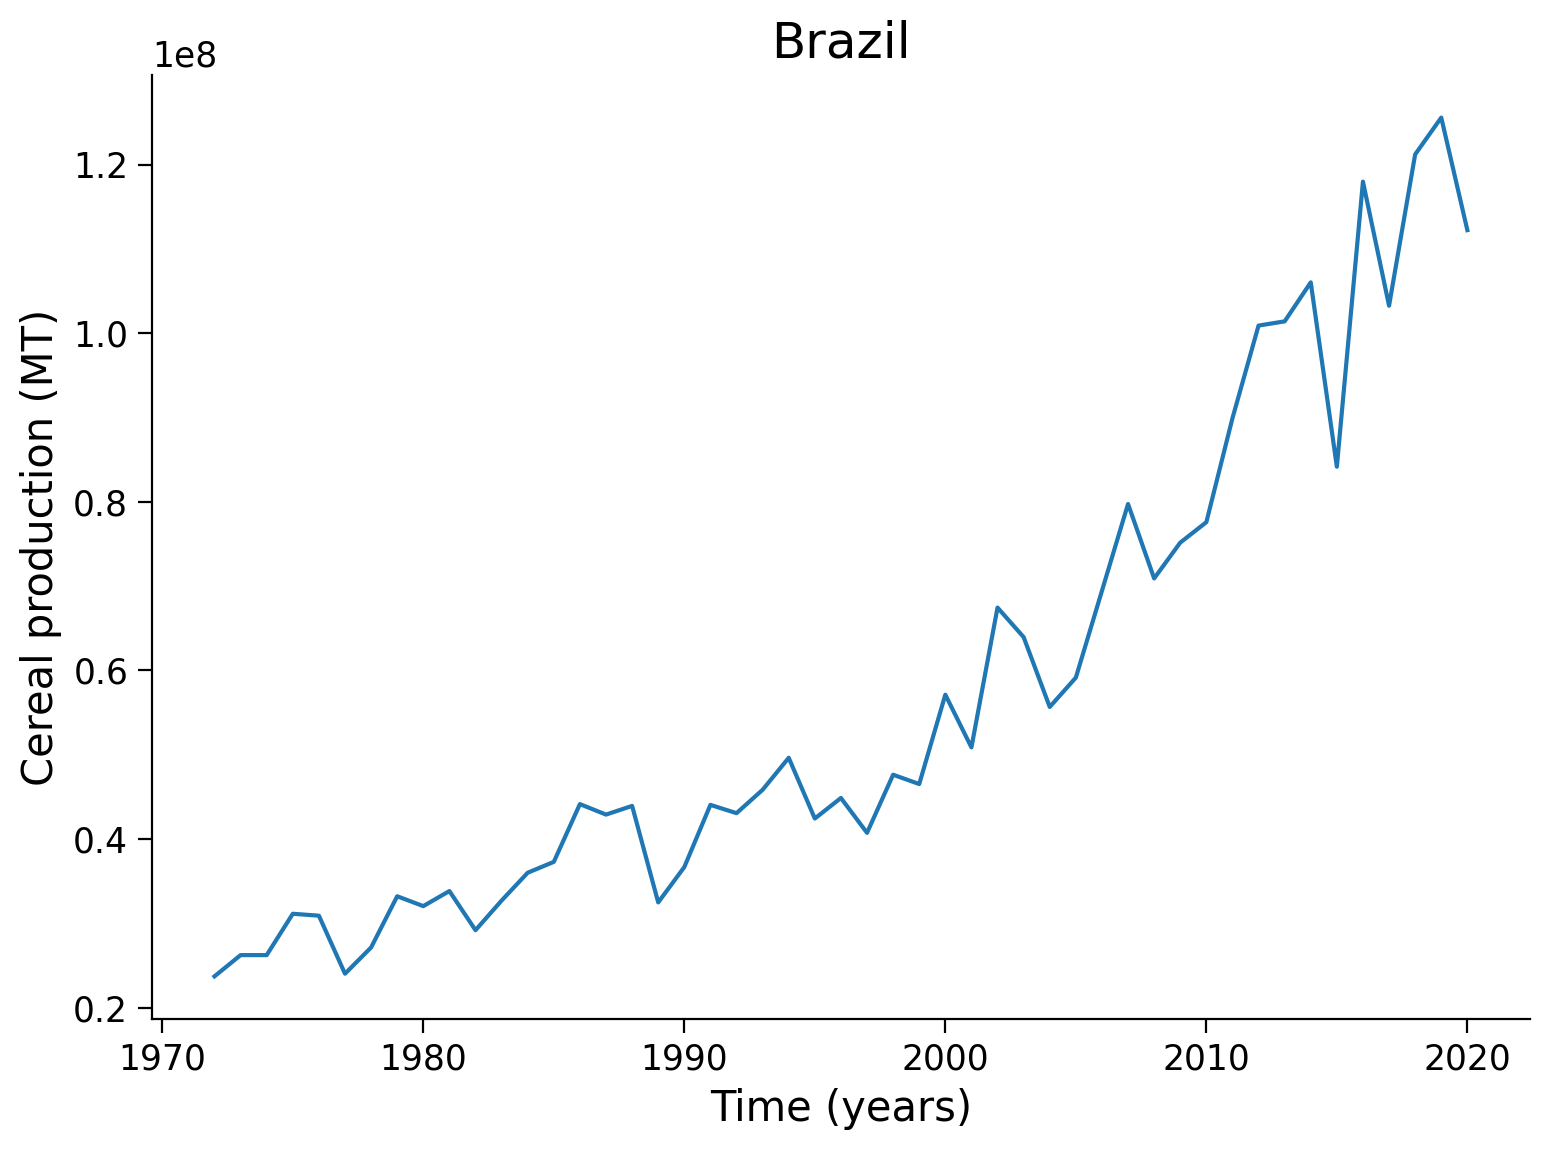

In [ ]:
# example
plt.plot(np.arange(1972,2021,1),ds_cereal_land_brazil[1:].astype(float).values)

# aesthetics
plt.title(f'{country}')
plt.xlabel(f'Time (years)')
plt.ylabel(f'Cereal production ({unit})')

Now you are all set to address the questions you are interested in!

# Q1

Plot the annual mean of precipitation for three example years (e.g., 2001, 2005, 2016) using the CHIRPS data sets.

*Hint: Check out the tutorials from [W1D1 (e.g. T4)](https://comptools.climatematch.io/tutorials/W1D1_ClimateSystemOverview/student/W1D1_Tutorial4.html#section-2-aggregation-methods), [W1D2 (e.g. T2)](https://comptools.climatematch.io/tutorials/W1D2_StateoftheClimateOceanandAtmosphereReanalysis/student/W1D2_Tutorial2.html#section-3-plotting-time-series-of-reanalysis-data) and [W1D3 (e.g. T5)](https://comptools.climatematch.io/tutorials/W1D3_RemoteSensingLandOceanandAtmosphere/student/W1D3_Tutorial5.html#section-2-2-global-mean) to recall averaging with `xarray`.*

# Q2
Plot the global mean of land precipitation as a function of time for the last 40 years.

*Hint: Check out the tutorials that contain time series calculations e.g. from [W1D2 (e.g. T1)](https://comptools.climatematch.io/tutorials/W1D2_StateoftheClimateOceanandAtmosphereReanalysis/student/W1D2_Tutorial1.html#section-2-3-compute-the-climatology-and-anomalies), [W1D3 (e.g. T5)](https://comptools.climatematch.io/tutorials/W1D3_RemoteSensingLandOceanandAtmosphere/student/W1D3_Tutorial5.html#section-2-2-global-mean) and [W1D5 (e.g. T8)](https://comptools.climatematch.io/tutorials/W1D5_ClimateModeling/student/W1D5_Tutorial8.html).*

Compute seasonal means for June-August (JJA) and December-February (DJF).

*Hint: Check out the code snippet in the **Indices for Extreme Events** section of this notebook. Furthermore, recall [Tutorial 5 of W1D1](https://comptools.climatematch.io/tutorials/W1D1_ClimateSystemOverview/student/W1D1_Tutorial5.html#section-1-groupby-split-apply-combine)*.

# Q3
Repeat the analysis in Q2 for a selected region of interest. How does this compare with the respective mean precipitation in the northern and southern hemispheres? How does this compare to the global mean?

*Hint: Check out tutorials that showed how to select certain regions of interest, e.g. [T8 and T9 of W1D1](https://comptools.climatematch.io/tutorials/W1D1_ClimateSystemOverview/student/W1D1_Tutorial9.html#section-3-using-where-with-specific-coordinates), [T1 of W1D2](https://comptools.climatematch.io/tutorials/W1D2_StateoftheClimateOceanandAtmosphereReanalysis/student/W1D2_Tutorial1.html) and others.*

# Q4
Examine the time series in your region of interest and identify extreme values. 

*Hint: Select a method from a predefined list of indices (provided above in Section **Indices for Extreme Events**) based on relative or absolute thresholds.*

Do extreme events occur more often in wet or dry seasons? 

*Hint: We briefly discussed wet and dry season differences in [Tutorial 4 of W1D3](https://comptools.climatematch.io/tutorials/W1D3_RemoteSensingLandOceanandAtmosphere/student/W1D3_Tutorial4.html#questions-2-2-climate-connection) already, however for another data set of monthly frequency namely the Global Precipitation Climatology Project (GPCP) Monthly Precipitation Climate Data Record (CDR) ([cf. Tutorial 4 of W1D3](https://comptools.climatematch.io/tutorials/W1D3_RemoteSensingLandOceanandAtmosphere/student/W1D3_Tutorial4.html#section-1-obtain-monthly-precipitation-data)). You also examined extreme events on W2D3.*

# Further Reading

- Anyamba, A. and Tucker, C.J., 2012. Historical perspective of AVHRR NDVI and vegetation drought monitoring. Remote sensing of drought: innovative monitoring approaches, 23, pp.20. [https://digitalcommons.unl.edu/nasapub/217/](https://digitalcommons.unl.edu/nasapub/217/)
- Schultz, P. A., and M. S. Halpert, 1993. Global correlation of temperature, NDVI and precipitation. Advances in Space Research 13(5). pp.277-280. [doi.org/10.1016/0273-1177(93)90559-T](https://doi.org/10.1016/0273-1177(93)90559-T) (not open access)
- Seneviratne, S.I. et al., 2021: Weather and Climate Extreme Events in a Changing Climate. In Climate Change 2021: The Physical Science Basis. Contribution of Working Group I to the Sixth Assessment Report of the Intergovernmental Panel on Climate Change [Masson-Delmotte, V. et al. (eds.)]. Cambridge University Press, Cambridge, United Kingdom and New York, NY, USA, pp.1513–1766, [https://www.ipcc.ch/report/ar6/wg1/chapter/chapter-11/](https://www.ipcc.ch/report/ar6/wg1/chapter/chapter-11/) 
- IPCC, 2021: Annex VI: Climatic Impact-driver and Extreme Indices [Gutiérrez J.M. et al.(eds.)]. In Climate Change 2021: The Physical Science Basis. Contribution of Working Group I to the Sixth Assessment Report of the Intergovernmental Panel on Climate Change [Masson-Delmotte, V. et al. (eds.)]. Cambridge University Press, Cambridge, United Kingdom and New York, NY, USA, pp. 2205–2214, [https://www.ipcc.ch/report/ar6/wg1/downloads/report/IPCC_AR6_WGI_AnnexVI.pdf](https://www.ipcc.ch/report/ar6/wg1/downloads/report/IPCC_AR6_WGI_AnnexVI.pdf)
- Zhang, X., Alexander, L., Hegerl, G.C., Jones, P., Tank, A.K., Peterson, T.C., Trewin, B. and Zwiers, F.W., 2011. Indices for monitoring changes in extremes based on daily temperature and precipitation data. Wiley Interdisciplinary Reviews: Climate Change, 2(6), pp.851-870. [doi.org/10.1002/wcc.147](https://doi.org/10.1002/wcc.147) (not open access)
